# Experimental Data Classification with Machine Learning

This notebook classifies time series data from two experimental conditions using SVM, LSTM, and Transformer models.

**Experiments:**
- 19316_2020_10_26_steadystate_glucose_144m_2w2_00 (label: 0)
- 20213_2021_09_07_steady_0p01glc_1344_1346_1347_00 (label: 1)

**Target:** CV_mCherry time series classification

<span style='color: red'>**== Run this notebook using the wela virtual environment ==**</span>

In [2]:
from wela.autocrosscorr import autocrosscorr
from wela.plotting import plot_column_from_tsv
from wela.get_exp_conditions import get_exp_summary # this is the function to print the experiment summary
from wela.calculate_stats import load_tsv, calculate_budding_intervals, calculate_cv, calculate_fano_factor, calculate_autocorrelation, calculate_ac_time_interp1d

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
from tqdm import tqdm
import glob

from scipy.interpolate import interp1d
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## Load the experiments and see their details

In [ ]:
# Define experiment metadata
omids = [
    '19316_2020_10_26_steadystate_glucose_144m_2w2_00',  # label: 0, 2% gluc
    '20213_2021_09_07_steady_0p01glc_1344_1346_1347_00',  # label: 1, 0.01% gluc
    # '19566_2020_12_07_steadystate_glucose_1344m_2w0p1_01', # 0.1% gluc
    # '19554_2020_12_06_steadystate_glucose_2w0p01_900m_00' # 0.01% gluc
]

# the acq and log files to get the exp descriptions
acq_file_path = glob.glob(f"/home/ianyang/alibylite/high_quality_data_analysis/{omids[0]}/*Acq.txt")[0]
log_file_path = glob.glob(f"/home/ianyang/alibylite/high_quality_data_analysis/{omids[0]}/*log.txt")[0]
# we only need the tf_df as a variable
summary_df, tf_df, _ = get_exp_summary(acq_file_path, log_file_path)
print(f"Loading data for experiment: {omids[0]}")
# we want the post media switch data
# Note this is not steady state yet...
tsv_path = f"/home/ianyang/stochastic_simulations/experiments/EXP-25-IY010/exp_data/{omids[0]}_post_media_switch.tsv"
column_name = 'CV_mCherry' # change this to 'CV_GFP' for GFP analysis
df_1 = load_tsv(tsv_path)
# group names
group_names = df_1['group'].unique().tolist()
# Convert group_names to strings to match tf_df['group'] data type
group_names_str = [str(g) for g in group_names]

# extract the TF being tracked by using the group_names as index
tf = tf_df.loc[tf_df['group'].isin(group_names_str), 'mCherry TF']

=== EXPERIMENT SUMMARY ===

📸 IMAGING SETUP (from acquisition file):
• Channels: ['Brightfield', 'GFP', 'mCherry']
• Exposure times: [30, 30, 100] ms
• Camera EM gain: 270

⏱️ TIME-LAPSE SETTINGS:
• Time interval: 120 seconds (2.0 minutes)
• Number of timepoints: 540
• Total experiment time: 64800 seconds (18.0 hours)

🧪 MICROFLUIDICS SETUP:
• Number of pumps: 2
• Pump rates: [[0.0], [4.0]]
• Pump contents: ['2% glucose in SC', '2% glucose in SC']
• Number of switches: 1
• Switch volumes: 50
• Switch rates: 100
• Switch times: [180]

🔬 MICROSCOPE SETUP (from log file):
• Microscope: Batgirl
• Date: 2020-10-25 00:00:00
• Experiment start time: 2020-10-25 17:09:13
• Capture of the first image: 2020-10-25 17:09:14
• MultiDGUI commit: 29bfe736500ed3f8be9c19585bee78cc67ceae26
• Experimental details: Aim:   Strain:   Comments:   Strains 1344 and 1346 were both labelled 1346 in the subculturing so not sure which is which.

💾 OMERO INFORMATION:
• Project: SteadystateGlucose
• Tags: ['25-Oct-20

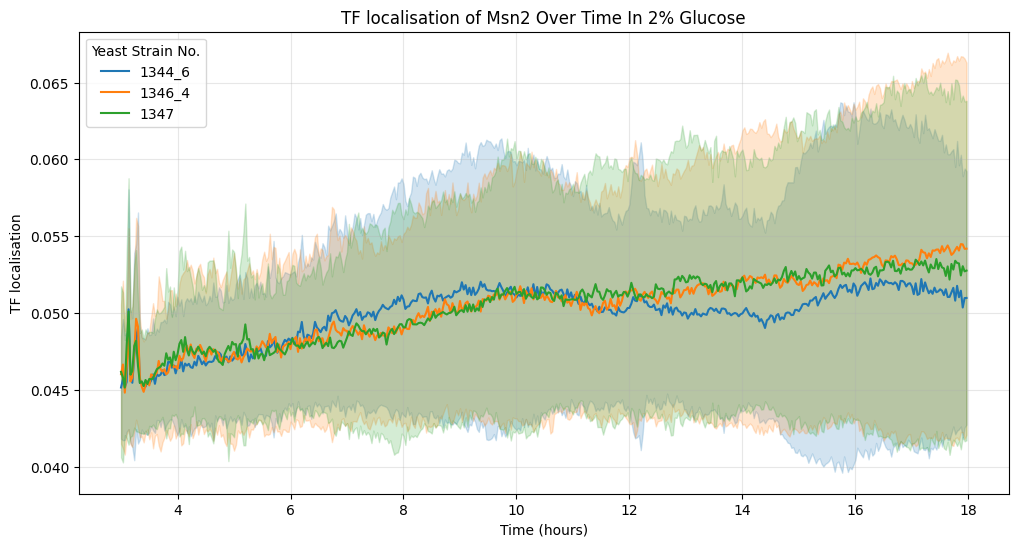

In [5]:
# Plot the required column over time for different groups
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_1, x='time', y=column_name, hue='group', errorbar='sd')
plt.legend(title=f'Yeast Strain No.')
plt.title(f'TF localisation of {tf.values[0]} Over Time In 2% Glucose')
plt.xlabel('Time (hours)')
plt.ylabel(f'TF localisation')
plt.grid(True, alpha=0.3)
plt.show()

=== EXPERIMENT SUMMARY ===

📸 IMAGING SETUP (from acquisition file):
• Channels: ['Brightfield', 'GFP', 'mCherry']
• Exposure times: [30, 30, 100] ms
• Camera EM gain: 270

⏱️ TIME-LAPSE SETTINGS:
• Time interval: 120 seconds (2.0 minutes)
• Number of timepoints: 540
• Total experiment time: 64800 seconds (18.0 hours)

🧪 MICROFLUIDICS SETUP:
• Number of pumps: 2
• Pump rates: [[-0.5], [4.5]]
• Pump contents: ['2% glucose in SC', '0.01% glucose in SC']
• Number of switches: 1
• Switch volumes: 50
• Switch rates: 100
• Switch times: [180]

🔬 MICROSCOPE SETUP (from log file):
• Microscope: Batgirl
• Date: 2021-09-06 00:00:00
• Experiment start time: 2021-09-06 17:18:07
• Capture of the first image: 2021-09-06 17:18:10
• MultiDGUI commit: e1ef7279bc3687c771624cf3b9503671aa6d7cea
• Experimental details: Aim: Record steady state TF dynamics in 0.01% glucose
Strains:
1344- Cat8-GFP Msn2-mCh
1346- Nrg1-GFP Msn2-mCh
1347- Rtg1-GFP Msn2-mCh
Comments:
Use Kevin's dilution sheet to prepare O/N (st

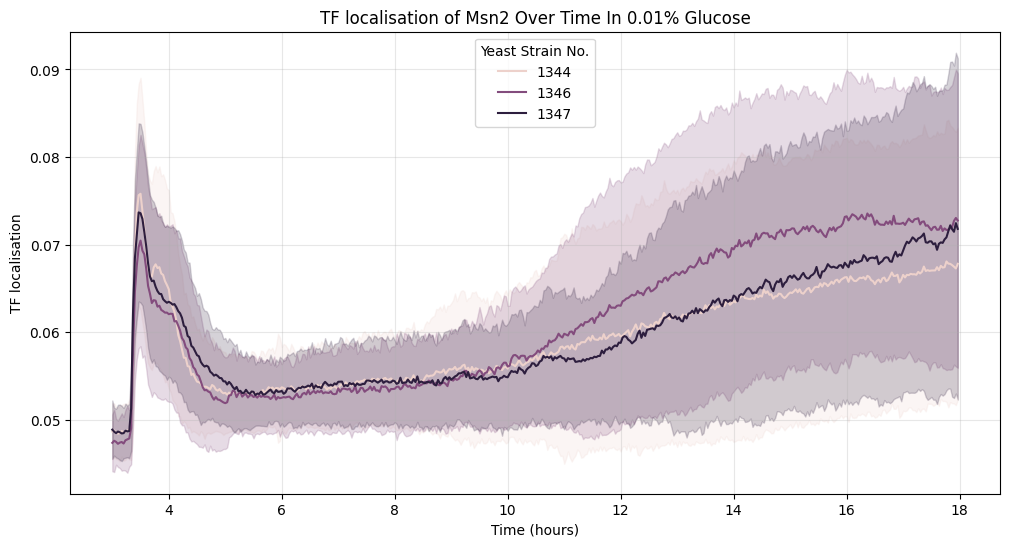

In [6]:
# the acq and log files to get the exp descriptions
acq_file_path = glob.glob(f"/home/ianyang/alibylite/high_quality_data_analysis/{omids[1]}/*Acq.txt")[0]
log_file_path = glob.glob(f"/home/ianyang/alibylite/high_quality_data_analysis/{omids[1]}/*log.txt")[0]
# we only need the tf_df as a variable
_, tf_df, _ = get_exp_summary(acq_file_path, log_file_path)
print(f"Loading data for experiment: {omids[1]}")
# we want the post media switch data
# Note this is not steady state yet...
tsv_path = f"/home/ianyang/stochastic_simulations/experiments/EXP-25-IY010/exp_data/{omids[1]}_post_media_switch.tsv"
column_name = 'CV_mCherry' # change this to 'CV_GFP' for GFP analysis
df_2 = load_tsv(tsv_path)
# group names
group_names = df_2['group'].unique().tolist()

# extract the TF being tracked by using the group_names as index
# Convert group_names to strings to match tf_df['group'] data type
group_names_str = [str(g) for g in group_names]
tf = tf_df.loc[tf_df['group'].isin(group_names_str), 'mCherry TF']

# Plot the required column over time for different groups
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_2, x='time', y=column_name, hue='group', errorbar='sd')
plt.legend(title=f'Yeast Strain No.')
plt.title(f'TF localisation of {tf.values[0]} Over Time In 0.01% Glucose')
plt.xlabel('Time (hours)')
plt.ylabel(f'TF localisation')
plt.grid(True, alpha=0.3)
plt.show()

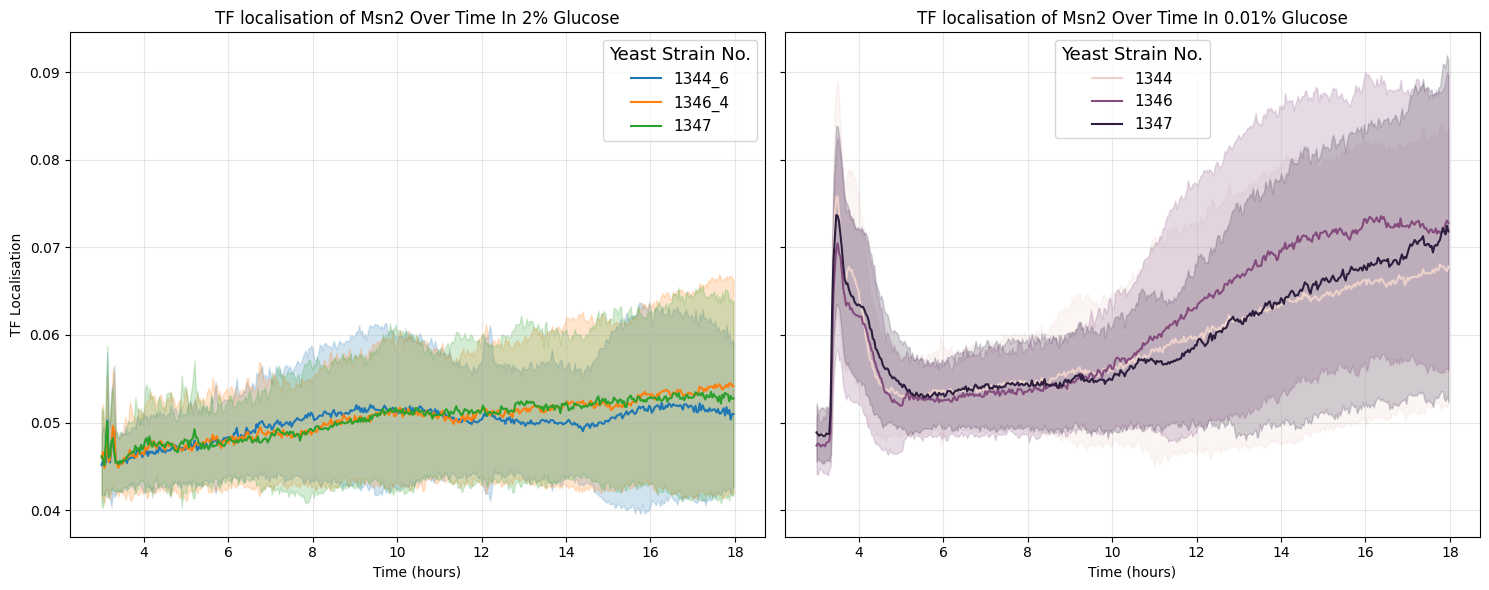

In [7]:
# Plot the 2 df in 2 subplots side by side for comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot for 2% glucose
sns.lineplot(data=df_1, x='time', y=column_name, hue='group', errorbar='sd', ax=axes[0])
axes[0].set_title(f'TF localisation of {tf.values[0]} Over Time In 2% Glucose')
axes[0].set_xlabel('Time (hours)')
#legend
axes[0].legend(title='Yeast Strain No.', title_fontsize='13', fontsize='11')
axes[0].set_ylabel(f'TF Localisation')
axes[0].grid(True, alpha=0.3)

# Plot for 0.01% glucose
sns.lineplot(data=df_2, x='time', y=column_name, hue='group', errorbar='sd', ax=axes[1])
axes[1].set_title(f'TF localisation of {tf.values[0]} Over Time In 0.01% Glucose')
axes[1].set_xlabel('Time (hours)')
axes[1].legend(title='Yeast Strain No.', title_fontsize='13', fontsize='11')
axes[1].set_ylabel(f'TF Localisation')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

-----------------------------------------------------------

## Processing the the data to extract the required columns

In [8]:
# get the CV_mCherry, group, time and id columns
df_1 = df_1[['CV_mCherry', 'group', 'time', 'id']]
df_2 = df_2[['CV_mCherry', 'group', 'time', 'id']]

def create_time_series_dataframes(df, experiment_name):
    """
    Transform dataframe to time series format where:
    - Each row is a unique id (time series)
    - Each column is a time point
    - Values are CV_mCherry measurements
    
    Returns a dictionary of dataframes, one for each group.
    """
    time_series_dfs = {}
    groups = df['group'].unique()
    
    print(f"\nProcessing {experiment_name}:")
    print(f"Found {len(groups)} groups: {groups}")
    
    for group in groups:
        print(f"  Processing group {group}...")
        
        # Filter data for this group
        group_data = df[df['group'] == group].copy()
        
        # Get unique ids and time points for this group
        unique_ids = group_data['id'].unique()
        time_points = sorted(group_data['time'].unique())
        
        print(f"    Group {group}: {len(unique_ids)} unique IDs, {len(time_points)} time points")
        
        # Create pivot table: rows=id, columns=time, values=CV_mCherry
        pivot_df = group_data.pivot(index='id', columns='time', values='CV_mCherry')
        
        # Reset index to make 'id' a regular column
        pivot_df = pivot_df.reset_index()
        
        # Add metadata columns
        pivot_df['group'] = group
        pivot_df['experiment'] = experiment_name
        
        # Reorder columns: metadata first, then time points
        metadata_cols = ['id', 'group', 'experiment']
        time_cols = [col for col in pivot_df.columns if col not in metadata_cols]
        pivot_df = pivot_df[metadata_cols + sorted(time_cols)]
        
        # Store in dictionary
        time_series_dfs[f'group_{group}'] = pivot_df
        
        print(f"    Created dataframe shape: {pivot_df.shape}")
        print(f"    Time range: {min(time_cols):.2f} to {max(time_cols):.2f}")
        print(f"    Missing values: {pivot_df.isnull().sum().sum()}")
    
    return time_series_dfs

# Process both experiments
exp1_time_series = create_time_series_dataframes(df_1, omids[0])
exp2_time_series = create_time_series_dataframes(df_2, omids[1])
print(f"\n" + "="*60)
print("DATA TRANSFORMATION SUMMARY")
print("="*60)
print(f"Experiment 1 ({omids[0][:30]}...):")
for key, df in exp1_time_series.items():
    print(f"  {key}: {df.shape[0]} time series x {df.shape[1]-3} time points")

print(f"\nExperiment 2 ({omids[1][:30]}...):")
for key, df in exp2_time_series.items():
    print(f"  {key}: {df.shape[0]} time series x {df.shape[1]-3} time points")


Processing 19316_2020_10_26_steadystate_glucose_144m_2w2_00:
Found 3 groups: ['1344_6' '1346_4' '1347']
  Processing group 1344_6...
    Group 1344_6: 71 unique IDs, 450 time points
    Created dataframe shape: (71, 453)
    Time range: 3.00 to 17.97
    Missing values: 298
  Processing group 1346_4...
    Group 1346_4: 84 unique IDs, 450 time points
    Created dataframe shape: (84, 453)
    Time range: 3.00 to 17.97
    Missing values: 387
  Processing group 1347...
    Group 1347: 78 unique IDs, 450 time points
    Created dataframe shape: (78, 453)
    Time range: 3.00 to 17.97
    Missing values: 391

Processing 20213_2021_09_07_steady_0p01glc_1344_1346_1347_00:
Found 3 groups: [1344 1346 1347]
  Processing group 1344...
    Group 1344: 241 unique IDs, 450 time points
    Created dataframe shape: (241, 453)
    Time range: 3.00 to 17.97
    Missing values: 179
  Processing group 1346...
    Group 1346: 231 unique IDs, 450 time points
    Created dataframe shape: (231, 453)
    Ti

## Handle Missing Data

In [ ]:
# Import necessary libraries for iterative imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

def handle_missing_values_dict(time_series_dict):
    """
    Handle missing values in dictionaries of dataframes using iterative imputation
    
    Parameters:
    -----------
    time_series_dict : dict
        Dictionary where keys are group names and values are DataFrames with time series data
        Each DataFrame should have columns: ['id', 'group', 'experiment'] + time_columns
    
    Returns:
    --------
    dict : Dictionary with same structure but missing values imputed
    """
    
    print("Processing missing values in time series dictionary with Iterative Imputer...")
    print(f"Found {len(time_series_dict)} groups to process")
    
    processed_dict = {}
    
    for group_name, df in time_series_dict.items():
        # print(f"\nProcessing group: {group_name}")
        # print(f"  DataFrame shape: {df.shape}")
        
        # Identify time columns (exclude metadata)
        metadata_cols = ['id', 'group', 'experiment']
        time_cols = [col for col in df.columns if col not in metadata_cols]
        time_cols = sorted(time_cols)  # Ensure consistent ordering
        
        # print(f"  Found {len(time_cols)} time columns")
        
        # Extract time series data matrix
        time_series_matrix = df[time_cols].values
        
        # print(f"  Time series matrix shape: {time_series_matrix.shape}")
        missing_count = np.isnan(time_series_matrix).sum()
        missing_percentage = (missing_count / time_series_matrix.size) * 100
        print(f" Missing values from {group_name}: {missing_count} ({missing_percentage:.1f}%)")
        
        # Check if imputation is needed
        if missing_count == 0:
            # print("  No missing values found. Keeping original data.")
            processed_dict[group_name] = df.copy()
            continue
        
        # Check if we have enough data for imputation
        if missing_percentage > 90:
            print("  ⚠️ Too many missing values (>90%). Using simple interpolation fallback.")
            processed_matrix = _apply_simple_interpolation(time_series_matrix)
        else:
            # iterative imputation
            try:
                # Use iterative imputer with linear regression
                imputer = IterativeImputer(
                    estimator=LinearRegression(),
                    random_state=42,
                    max_iter=10,
                    tol=1e-3,
                    imputation_order='ascending',
                    verbose=0
                )
                
                processed_matrix = imputer.fit_transform(time_series_matrix)
                
                remaining_nan = np.isnan(processed_matrix).sum()
                print(f"  Imputation completed. Remaining NaN values: {remaining_nan}")
                
                # Apply fallback for any remaining NaN values
                if remaining_nan > 0:
                    # print("  Applying fallback methods for remaining NaN values...")
                    processed_matrix = _apply_fallback_imputation(processed_matrix)
                
            except Exception as e:
                print(f"  ⚠️ Iterative imputation failed: {str(e)}")
                print("  Falling back to simple interpolation...")
                processed_matrix = _apply_simple_interpolation(time_series_matrix)
        
        # Create new dataframe with imputed values
        processed_df = df.copy()
        processed_df[time_cols] = processed_matrix
        
        # Verify no NaN values remain
        final_nan_count = processed_df[time_cols].isna().sum().sum()
        if final_nan_count > 0:
            print(f"  ⚠️ Warning: {final_nan_count} NaN values still remain. Applying final cleanup...")
            # Fill any remaining NaN with column medians
            for col in time_cols:
                if processed_df[col].isna().any():
                    median_val = processed_df[col].median()
                    if pd.isna(median_val):  # If median is also NaN, use global median
                        global_median = processed_df[time_cols].median().median()
                        processed_df[col] = processed_df[col].fillna(global_median)
                    else:
                        processed_df[col] = processed_df[col].fillna(median_val)
        
        processed_dict[group_name] = processed_df
        # print(f"  ✅ Group {group_name} processed successfully")
        # print(f"  Final shape: {processed_df.shape}")
        # print(f"  Final missing values: {processed_df[time_cols].isna().sum().sum()}")
    
    # print(f"\n✅ All {len(time_series_dict)} groups processed successfully!")
    return processed_dict

def _apply_simple_interpolation(matrix):
    """Apply simple interpolation to each row of the matrix"""
    processed_matrix = matrix.copy()
    
    for i in range(matrix.shape[0]):
        series = pd.Series(matrix[i])
        # Linear interpolation
        series = series.interpolate(method='linear', limit_direction='both')
        # Forward/backward fill for edges
        series = series.fillna(method='ffill').fillna(method='bfill')
        processed_matrix[i] = series.values
    
    return processed_matrix

def _apply_fallback_imputation(matrix):
    """Apply fallback imputation methods for remaining NaN values"""
    processed_matrix = matrix.copy()
    
    for i in range(matrix.shape[0]):
        series = pd.Series(matrix[i])
        if series.isna().any():
            # Try forward/backward fill first
            series = series.fillna(method='ffill').fillna(method='bfill')
            
            # If still NaN, use global median
            if series.isna().any():
                global_median = np.nanmedian(matrix)
                series = series.fillna(global_median)
            
            processed_matrix[i] = series.values
    
    return processed_matrix

In [ ]:
# Process both experiments
exp1_processed = handle_missing_values_dict(exp1_time_series)
print("\n" + "="*55)
exp2_processed = handle_missing_values_dict(exp2_time_series)

print(f"\n📊 PROCESSING SUMMARY:")
print(f"Experiment 1: {len(exp1_processed)} groups processed")
print(f"Experiment 2: {len(exp2_processed)} groups processed")

# Verify the structure is preserved
for group_name, df in exp1_processed.items():
    print(f"  Exp1 {group_name}: {df.shape}")
    
for group_name, df in exp2_processed.items():
    print(f"  Exp2 {group_name}: {df.shape}")

# Check for any remaining missing values
print(f"\n🔍 FINAL VALIDATION:")
for exp_name, exp_dict in [("Experiment 1", exp1_processed), ("Experiment 2", exp2_processed)]:
    total_missing = 0
    for group_name, df in exp_dict.items():
        time_cols = [col for col in df.columns if col not in ['id', 'group', 'experiment']]
        missing_in_group = df[time_cols].isna().sum().sum()
        total_missing += missing_in_group
        if missing_in_group > 0:
            print(f"  ⚠️ {exp_name} {group_name}: {missing_in_group} missing values")
    
    if total_missing == 0:
        print(f"  ✅ {exp_name}: No missing values detected!")
    else:
        print(f"  ⚠️ {exp_name}: {total_missing} total missing values")

TESTING DICTIONARY-BASED MISSING VALUE HANDLING
Processing missing values in time series dictionary with Iterative Imputer...
Found 3 groups to process
 Missing values from group_1344_6: 298 (0.9%)
  Imputation completed. Remaining NaN values: 0
 Missing values from group_1346_4: 387 (1.0%)
  Imputation completed. Remaining NaN values: 0
 Missing values from group_1346_4: 387 (1.0%)
  Imputation completed. Remaining NaN values: 0
 Missing values from group_1347: 391 (1.1%)
  Imputation completed. Remaining NaN values: 0
 Missing values from group_1347: 391 (1.1%)
  Imputation completed. Remaining NaN values: 0

Processing missing values in time series dictionary with Iterative Imputer...
Found 3 groups to process
 Missing values from group_1344: 179 (0.2%)
  Imputation completed. Remaining NaN values: 0

Processing missing values in time series dictionary with Iterative Imputer...
Found 3 groups to process
 Missing values from group_1344: 179 (0.2%)
  Imputation completed. Remaining Na

## Extract steady state data 

In [11]:
def _detect_initial_burst(values, time_points, burst_window=5, burst_threshold=0.2, min_burst_duration=3):
    """
    Detect initial burst phase where values are changing rapidly.
    Returns the index where the burst ends and steady state detection should begin.
    
    Parameters:
    -----------
    values : array
        Time series values
    burst_window : int
        Window size for detecting burst activity
    burst_threshold : float
        Relative change threshold to consider as burst activity
    min_burst_duration : int
        Minimum duration of stable period to confirm burst has ended
    
    Returns:
    --------
    int : Index where burst ends (or 0 if no burst detected)
    """
    # Need enough data points to assess burst
    if len(values) < burst_window + min_burst_duration:
        return 0
    
    # Calculate relative changes using sliding windows
    burst_end_idx = 0
    
    for i in range(burst_window, len(values) - min_burst_duration):
        if pd.isna(values[i]):
            continue
        
        # Look at the window before current point to assess if burst activity has ceased
        window_values = values[max(0, i-burst_window):i]
        valid_window = window_values[~pd.isna(window_values)]
        
        if len(valid_window) < burst_window * 0.8:  # Need sufficient data
            continue
        
        # Calculate coefficient of variation in the recent window
        window_mean = np.mean(valid_window)
        window_std = np.std(valid_window)
        
        if window_mean == 0:
            cv = 0
        else:
            cv = window_std / abs(window_mean)
        
        # If coefficient of variation is low, check if this stable period persists
        if cv <= burst_threshold:
            # Check if the next min_burst_duration windows also show stability
            is_stable_period = True
            for j in range(i, min(i + min_burst_duration, len(values))):
                if pd.isna(values[j]):
                    continue
                
                # Check stability in a small window around point j
                local_window = values[max(0, j-2):min(len(values), j+3)]
                valid_local = local_window[~pd.isna(local_window)]
                
                if len(valid_local) >= 3:
                    local_mean = np.mean(valid_local)
                    local_std = np.std(valid_local)
                    local_cv = local_std / abs(local_mean) if local_mean != 0 else 0
                    
                    if local_cv > burst_threshold:
                        is_stable_period = False
                        break
            
            if is_stable_period:
                burst_end_idx = i
                break
    
    return burst_end_idx

def filter_steady_state_data(time_series_dict, window_size=10, tolerance=0.10, min_steady_duration=3, detect_end=True, burst_threshold=0.15):
    """
    Filter each group's dataframe to include only steady state time points.
    First detects and skips initial burst phases, then identifies steady state periods
    where sliding window means stabilize within tolerance. Optionally detects end of 
    steady state when values start deviating beyond tolerance again.
    
    Parameters:
    -----------
    time_series_dict : dict
        Dictionary of dataframes with time series data
    window_size : int, default=10
        Size of sliding window for calculating mean values
    tolerance : float, default=0.10
        Relative tolerance for detecting steady state (10% by default)
    min_steady_duration : int, default=3
        Minimum number of consecutive windows that must be steady
    detect_end : bool, default=True
        Whether to detect and cut off at the end of steady state
    
    Returns:
    --------
    dict : Filtered dictionary with steady state data only
    
    Notes:
    ------
    The function includes burst detection to avoid trying to extract steady state
    from inherently unstable initial burst periods. Steady state detection begins
    only after the initial burst phase ends.
    """
    filtered_dict = {}
    
    for group, df in time_series_dict.items():
        print(f"\nDetecting steady state for {group}...")
        
        # Identify time columns (exclude metadata)
        time_cols = [col for col in df.columns if isinstance(col, (int, float))]
        time_cols = sorted(time_cols)
        
        if len(time_cols) < window_size + min_steady_duration:
            print(f"  Not enough time points ({len(time_cols)}) for analysis. Skipping...")
            continue
        
        # Calculate sliding window means for each time series
        steady_start_times = []
        steady_end_times = []
        burst_end_times = []
        
        for idx, row in df.iterrows():
            series_values = row[time_cols].values
            
            # Skip if too many NaN values
            valid_mask = ~pd.isna(series_values)
            if np.sum(valid_mask) < window_size + min_steady_duration:
                continue
            
            # Detect end of initial burst
            burst_end_idx = _detect_initial_burst(series_values, time_cols, burst_threshold=burst_threshold)
            
            # Start steady state detection after burst period
            analysis_start_idx = max(burst_end_idx, window_size)
            if analysis_start_idx >= len(series_values) - min_steady_duration:
                continue  # Not enough data after burst for analysis
            
            # Store burst information for this time series
            if burst_end_idx > 0:
                burst_end_times.append(time_cols[burst_end_idx])
            else:
                burst_end_times.append(np.nan)
                
            # Calculate sliding window means starting from after the burst
            window_means = []
            window_time_points = []
            
            for i in range(analysis_start_idx, len(time_cols) - window_size + 1):
                window_values = series_values[i:i + window_size]
                if np.sum(~pd.isna(window_values)) >= window_size * 0.8:  # At least 80% valid data in window
                    mean_val = np.nanmean(window_values)
                    window_means.append(mean_val)
                    window_time_points.append(time_cols[i + window_size - 1])  # Use end of window as time point
                else:
                    window_means.append(np.nan)
                    window_time_points.append(time_cols[i + window_size - 1])
            
            # Detect steady state: find first window where subsequent windows are within tolerance
            steady_start_idx = None
            
            for i in range(len(window_means) - min_steady_duration):
                if pd.isna(window_means[i]):
                    continue
                    
                reference_mean = window_means[i]
                if reference_mean == 0:  # Avoid division by zero
                    reference_mean = 1e-10
                
                # Check if next min_steady_duration windows are within tolerance
                is_steady = True
                for j in range(i + 1, min(i + 1 + min_steady_duration, len(window_means))):
                    if pd.isna(window_means[j]):
                        is_steady = False
                        break
                    
                    relative_diff = abs(window_means[j] - reference_mean) / abs(reference_mean)
                    if relative_diff > tolerance:
                        is_steady = False
                        break
                
                if is_steady:
                    steady_start_idx = i
                    break
            
            # Detect end of steady state if enabled
            steady_end_idx = None
            if detect_end and steady_start_idx is not None:
                # Look for end of steady state starting from steady_start_idx
                for i in range(steady_start_idx + min_steady_duration, len(window_means) - min_steady_duration):
                    if pd.isna(window_means[i]):
                        continue
                    
                    # Use the established steady state mean as reference
                    reference_mean = window_means[steady_start_idx]
                    if reference_mean == 0:
                        reference_mean = 1e-10
                    
                    # Check if current window starts deviating beyond tolerance
                    current_diff = abs(window_means[i] - reference_mean) / abs(reference_mean)
                    
                    if current_diff > tolerance:
                        # Check if deviation persists for min_steady_duration windows
                        is_end_steady = True
                        for j in range(i + 1, min(i + 1 + min_steady_duration, len(window_means))):
                            if pd.isna(window_means[j]):
                                continue
                            next_diff = abs(window_means[j] - reference_mean) / abs(reference_mean)
                            if next_diff <= tolerance:
                                is_end_steady = False
                                break
                        
                        if is_end_steady:
                            steady_end_idx = i
                            break
            
            if steady_start_idx is not None:
                # Convert window index back to time point
                steady_start_time = window_time_points[steady_start_idx]
                steady_start_times.append(steady_start_time)
                
                # Store end time if detected
                if steady_end_idx is not None:
                    steady_end_time = window_time_points[steady_end_idx]
                    steady_end_times.append(steady_end_time)
                else:
                    steady_end_times.append(np.nan)
            else:
                steady_start_times.append(np.nan)
                steady_end_times.append(np.nan)
                burst_end_times.append(np.nan)
        
        # Remove NaN values and find the median steady start time
        valid_steady_times = [t for t in steady_start_times if not pd.isna(t)]
        
        if not valid_steady_times:
            print(f"  No steady state detected for any time series in {group}. Skipping...")
            continue
        
        # Use median or earliest steady start time
        start_time = np.median(valid_steady_times)
        
        # Handle burst detection results
        valid_burst_times = [t for t in burst_end_times if not pd.isna(t)]
        if valid_burst_times:
            median_burst_end = np.median(valid_burst_times)
            print(f"  Detected initial burst ending at time: {median_burst_end:.2f} hours")
            print(f"  Based on {len(valid_burst_times)}/{len(burst_end_times)} time series")
            print(f"  Burst duration: {median_burst_end:.2f} hours")
        else:
            print(f"  No significant initial burst detected")
        
        # Handle steady state end detection
        end_time = None
        if detect_end:
            valid_end_times = [t for t in steady_end_times if not pd.isna(t)]
            if valid_end_times:
                end_time = np.median(valid_end_times)
                print(f"  Detected steady state ending at time: {end_time:.2f} hours")
                print(f"  Based on {len(valid_end_times)}/{len(steady_end_times)} time series")
        
        print(f"  Detected steady state starting at time: {start_time:.2f} hours")
        print(f"  Based on {len(valid_steady_times)}/{len(steady_start_times)} time series")
        
        # Filter time columns based on detected steady state
        if end_time is not None:
            steady_time_cols = [col for col in time_cols if start_time <= col <= end_time]
        else:
            steady_time_cols = [col for col in time_cols if col >= start_time]
        
        if not steady_time_cols:
            print(f"  No time points after steady state start. Skipping...")
            continue
        
        # Create new dataframe with metadata + steady state time points
        filtered_df = df[['id', 'group', 'experiment'] + steady_time_cols].copy()
        
        # Drop rows with all NaNs in the steady state columns
        filtered_df = filtered_df.dropna(subset=steady_time_cols, how='all')
        
        print(f"  Original shape: {df.shape}, Filtered shape: {filtered_df.shape}")
        print(f"  Time range after filtering: {min(steady_time_cols):.2f} to {max(steady_time_cols):.2f}")
        if end_time is not None:
            print(f"  Steady state duration: {end_time - start_time:.2f} hours")
        print(f"  Missing values after filtering: {filtered_df.isnull().sum().sum()}")
        print(f"  Steady state parameters: window_size={window_size}, tolerance={tolerance*100:.1f}%, min_duration={min_steady_duration}")
        if detect_end:
            print(f"  End detection: {'Enabled' if detect_end else 'Disabled'}")
        
        filtered_dict[group] = filtered_df
    
    return filtered_dict

In [12]:
#TODO: rewrite the above function
def extract_steady_state(time_series_dict, window_size=10, ):
    '''
    Extract steady state data from each group's dataframe.
    
    '''
    
    extracted_dict = {}
    
    for group, df in time_series_dict.items():
        
        # time columns (exclude metadata)
        time_cols = [col for col in df.columns if isinstance(col, (int, float))]
        time_cols = sorted(time_cols)
    
    

In [13]:
# Visualize the time series data structure
import matplotlib.pyplot as plt
import seaborn as sns

def plot_time_series_overview(time_series_dict, experiment_name, max_series=5):
    """Plot overview of time series data for each group"""
    
    fig, axes = plt.subplots(len(time_series_dict), 1, figsize=(15, 4*len(time_series_dict)))
    if len(time_series_dict) == 1:
        axes = [axes]
    
    for idx, (group_name, df) in enumerate(time_series_dict.items()):
        ax = axes[idx]
        
        # Get time columns (exclude metadata columns)
        time_cols = [col for col in df.columns if col not in ['id', 'group', 'experiment']]
        time_values = [float(col) for col in time_cols]
        
        # Plot first few time series
        n_series = min(max_series, len(df))
        for i in range(n_series):
            cv_values = df.iloc[i][time_cols].values
            # Only plot non-NaN values
            valid_mask = ~pd.isna(cv_values)
            if valid_mask.any():
                ax.plot([time_values[j] for j in range(len(time_values)) if valid_mask[j]], 
                       cv_values[valid_mask], alpha=0.7, label=f'ID {df.iloc[i]["id"]}')
        
        ax.set_title(f'{experiment_name} - {group_name}\n({len(df)} total time series)')
        ax.set_xlabel('Time (hours)')
        ax.set_ylabel('CV_mCherry')
        ax.grid(True, alpha=0.3)
        if n_series <= 10:  # Only show legend if not too many series
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()


Detecting steady state for group_1344_6...
  Detected initial burst ending at time: 3.17 hours
  Based on 71/71 time series
  Burst duration: 3.17 hours
  Detected steady state ending at time: 8.07 hours
  Based on 52/71 time series
  Detected steady state starting at time: 4.97 hours
  Based on 71/71 time series
  Original shape: (71, 453), Filtered shape: (71, 97)
  Time range after filtering: 4.97 to 8.07
  Steady state duration: 3.10 hours
  Missing values after filtering: 0
  Steady state parameters: window_size=30, tolerance=10.0%, min_duration=5
  End detection: Enabled

Detecting steady state for group_1346_4...
  Detected initial burst ending at time: 3.17 hours
  Based on 71/71 time series
  Burst duration: 3.17 hours
  Detected steady state ending at time: 8.07 hours
  Based on 52/71 time series
  Detected steady state starting at time: 4.97 hours
  Based on 71/71 time series
  Original shape: (71, 453), Filtered shape: (71, 97)
  Time range after filtering: 4.97 to 8.07
  

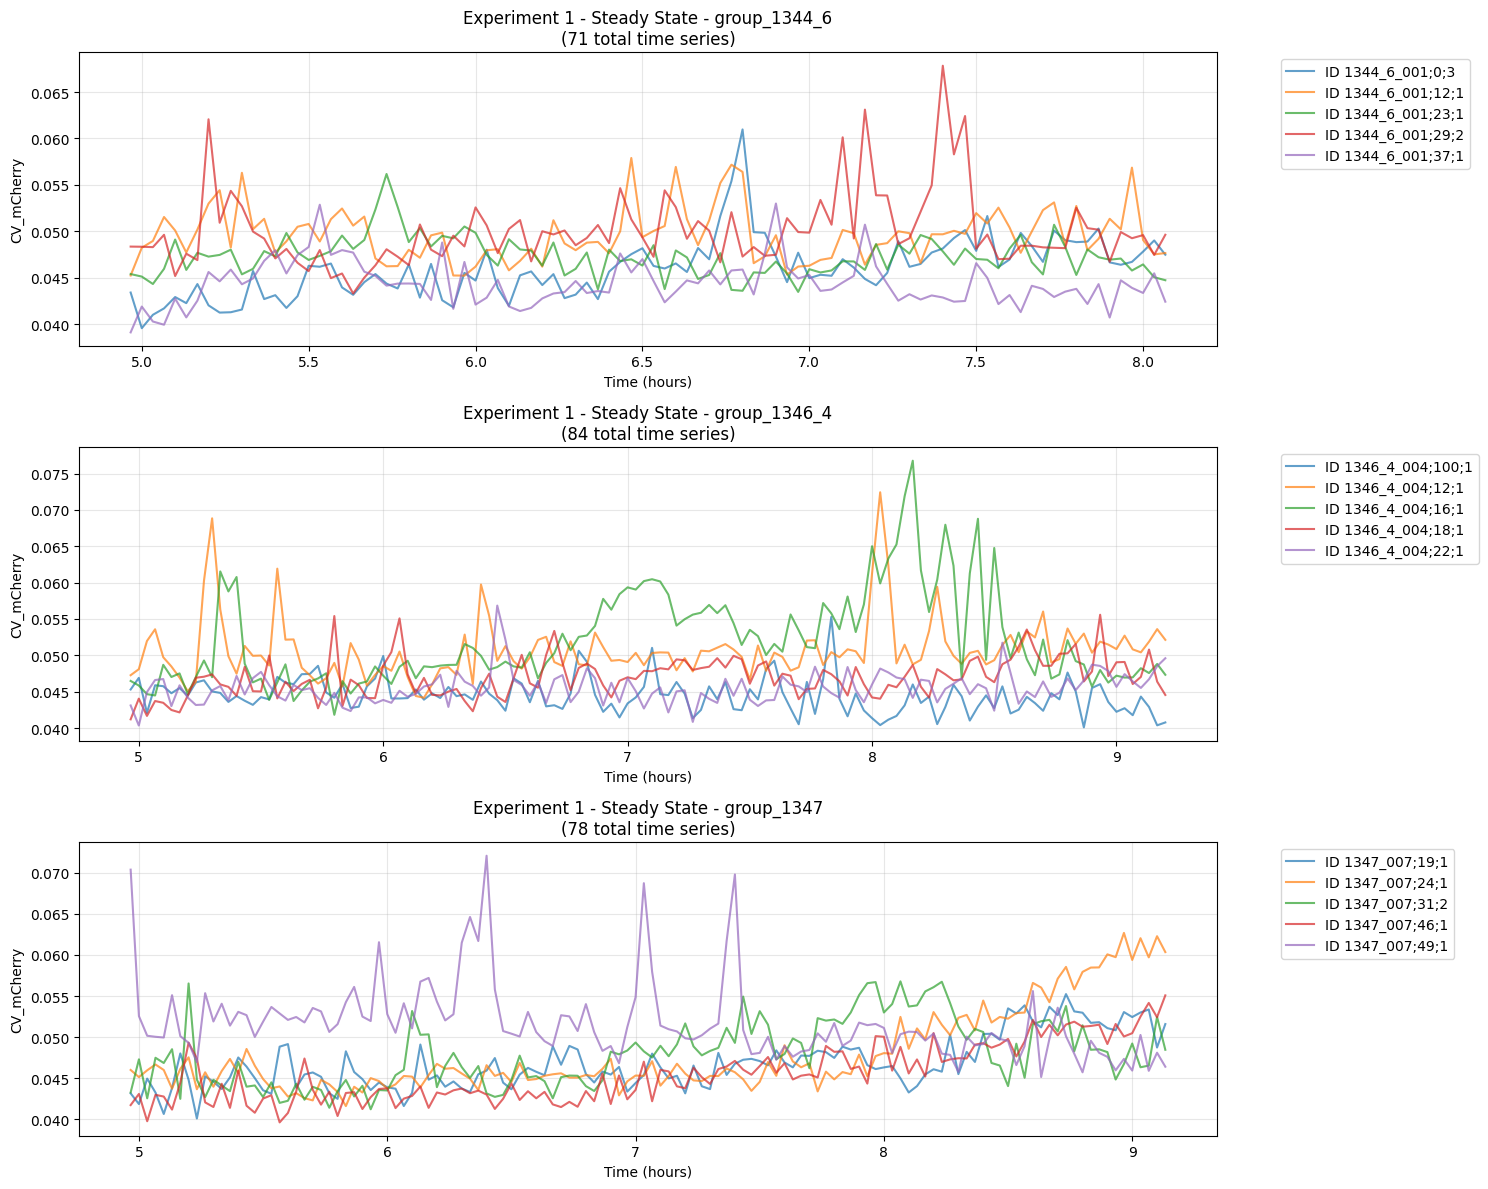

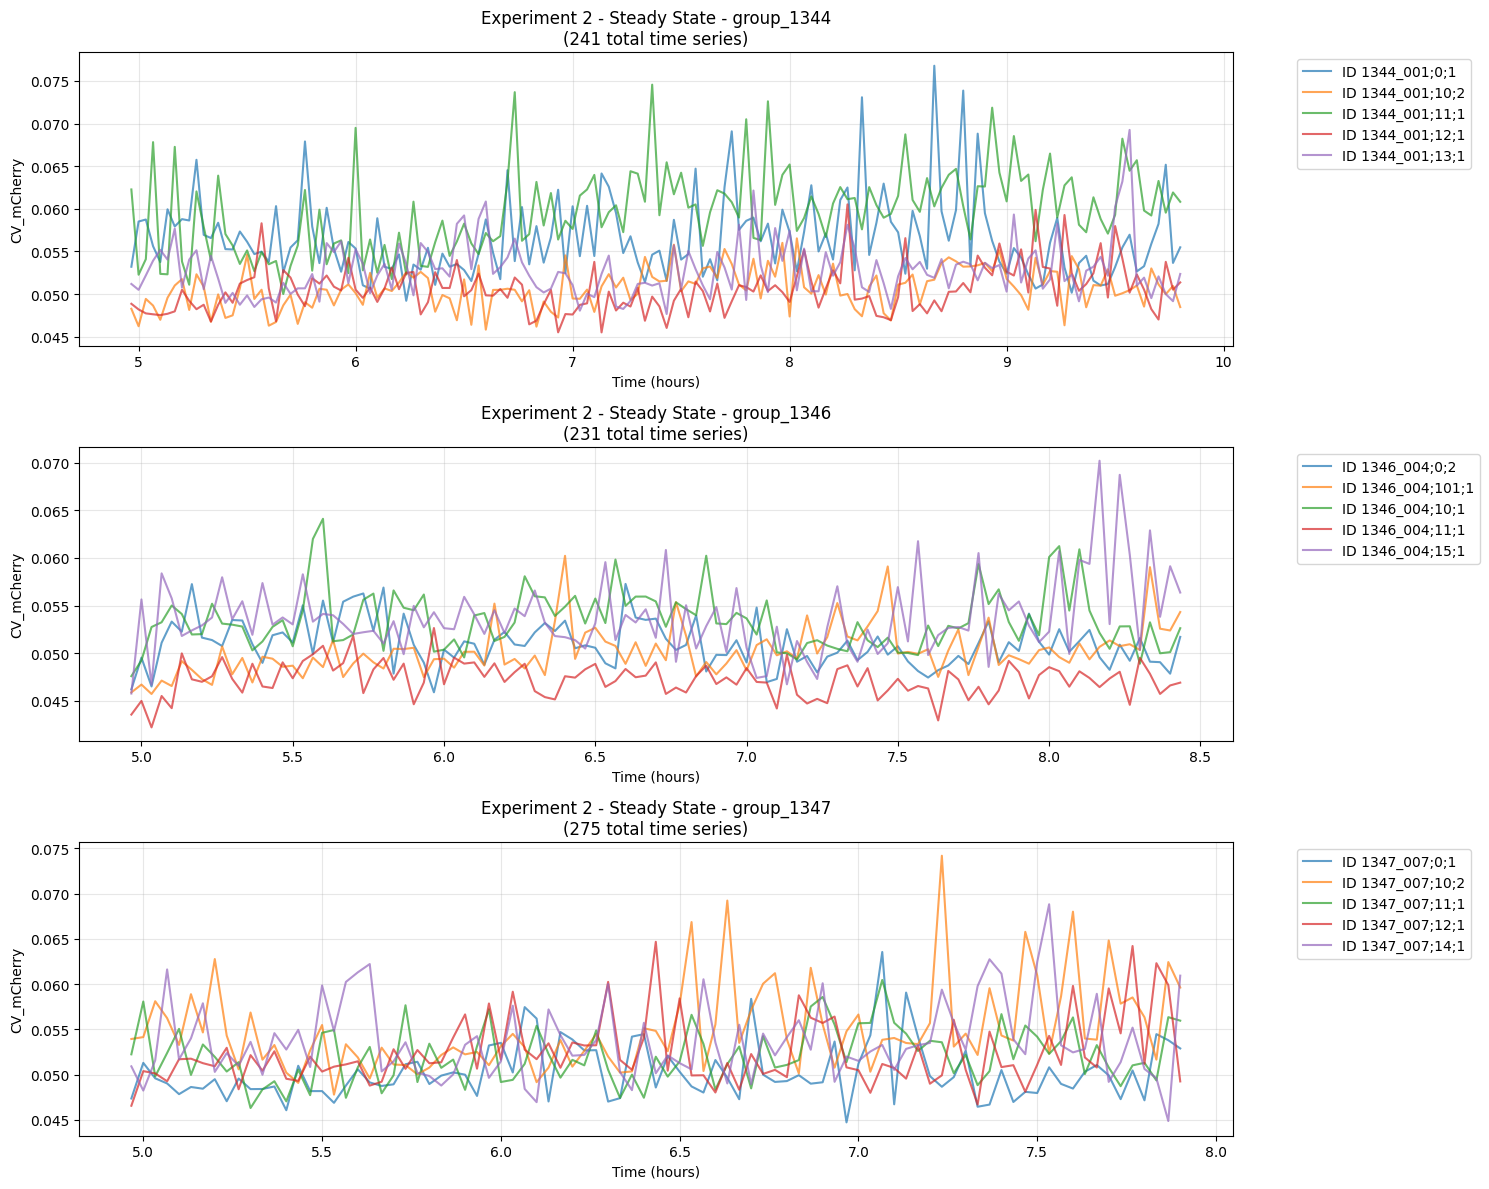

In [14]:
# get only the steady data
exp1_ss_time_series = filter_steady_state_data(exp1_processed, window_size=30, tolerance=0.10, min_steady_duration=5, burst_threshold=0.1)
exp2_ss_time_series = filter_steady_state_data(exp2_processed, window_size=30, tolerance=0.10, min_steady_duration=5, burst_threshold=0.1)

# Visualize the steady state time series
plot_time_series_overview(exp1_ss_time_series, "Experiment 1 - Steady State")
plot_time_series_overview(exp2_ss_time_series, "Experiment 2 - Steady State")

In [16]:
# since the number of time series in each group is different, we will take the minimum number of time series across all groups for training
min_series_exp1 = min(df.shape[0] for df in exp1_ss_time_series.values())
min_series_exp2 = min(df.shape[0] for df in exp2_ss_time_series.values())

# the min across all experiments
min_series = min(min_series_exp1, min_series_exp2)

# take out the first however many time series from each group to make them balanced
exp1_time_series_balanced = {k: df.iloc[:min_series] for k, df in exp1_ss_time_series.items()}
exp2_time_series_balanced = {k: df.iloc[:min_series] for k, df in exp2_ss_time_series.items()}

In [ ]:
def find_min_timepoints(time_series_dict, dict_name):
    """Find minimum number of timepoints across all time series in a dictionary"""
    min_timepoints = float('inf')
    timepoint_stats = []
    
    for group_name, df in time_series_dict.items():
        # Get time columns (exclude metadata)
        time_cols = [col for col in df.columns if col not in ['id', 'group', 'experiment']]
        num_timepoints = len(time_cols)
        timepoint_stats.append((group_name, num_timepoints))
        min_timepoints = min(min_timepoints, num_timepoints)
        
        print(f"  {dict_name} {group_name}: {num_timepoints} timepoints")
    
    return min_timepoints, timepoint_stats

# Find minimum timepoints for both experiments
min_timepoints_exp1, stats_exp1 = find_min_timepoints(exp1_time_series_balanced, "Exp1")
print()
min_timepoints_exp2, stats_exp2 = find_min_timepoints(exp2_time_series_balanced, "Exp2")

# Get the global minimum across both experiments
global_min_timepoints = min(min_timepoints_exp1, min_timepoints_exp2)

print(f"\n📊 TIMEPOINT STATISTICS:")
print(f"  Exp1 minimum timepoints: {min_timepoints_exp1}")
print(f"  Exp2 minimum timepoints: {min_timepoints_exp2}")
print(f"  Global minimum timepoints: {global_min_timepoints}")

def truncate_to_min_timepoints(time_series_dict, min_timepoints, dict_name):
    """Truncate all time series to have the same number of timepoints"""
    truncated_dict = {}
    
    for group_name, df in time_series_dict.items():
        # Get time columns and metadata columns
        metadata_cols = ['id', 'group', 'experiment']
        time_cols = [col for col in df.columns if col not in metadata_cols]
        time_cols = sorted(time_cols)  # Ensure consistent ordering
        
        # Take only the first min_timepoints time columns
        selected_time_cols = time_cols[:min_timepoints]
        
        # Create new dataframe with metadata + selected time columns
        truncated_df = df[metadata_cols + selected_time_cols].copy()
        
        truncated_dict[group_name] = truncated_df
        
        print(f"  {dict_name} {group_name}: {len(time_cols)} → {len(selected_time_cols)} timepoints")
    
    return truncated_dict

print(f"\n🔧 TRUNCATING TO {global_min_timepoints} TIMEPOINTS:")
exp1_time_series_truncated = truncate_to_min_timepoints(exp1_time_series_balanced, global_min_timepoints, "Exp1")
exp2_time_series_truncated = truncate_to_min_timepoints(exp2_time_series_balanced, global_min_timepoints, "Exp2")

print(f"\n✅ All time series now have exactly {global_min_timepoints} timepoints!")

# Update the balanced datasets to use the truncated versions
exp1_time_series_balanced = exp1_time_series_truncated
exp2_time_series_balanced = exp2_time_series_truncated

FINDING MINIMUM NUMBER OF TIMEPOINTS
  Exp1 group_1344_6: 94 timepoints
  Exp1 group_1346_4: 128 timepoints
  Exp1 group_1347: 126 timepoints

  Exp2 group_1344: 146 timepoints
  Exp2 group_1346: 105 timepoints
  Exp2 group_1347: 89 timepoints

📊 TIMEPOINT STATISTICS:
  Exp1 minimum timepoints: 94
  Exp2 minimum timepoints: 89
  Global minimum timepoints: 89

🔧 TRUNCATING TO 89 TIMEPOINTS:
  Exp1 group_1344_6: 94 → 89 timepoints
  Exp1 group_1346_4: 128 → 89 timepoints
  Exp1 group_1347: 126 → 89 timepoints
  Exp2 group_1344: 146 → 89 timepoints
  Exp2 group_1346: 105 → 89 timepoints
  Exp2 group_1347: 89 → 89 timepoints

✅ All time series now have exactly 89 timepoints!


In [20]:
# Display sample of transformed data
print("SAMPLE OF TRANSFORMED DATA")
print("="*50)
# Use a balanced dataset
# Show first group from each experiment
first_group_exp1 = list(exp1_time_series_balanced.keys())[0]
sample_df1 = exp1_time_series_balanced[first_group_exp1]
print(f"\nExperiment 1 - {first_group_exp1}:")
print(f"Shape: {sample_df1.shape}")
print("First 5 rows and first 8 columns:")
display_cols = sample_df1.columns[:8]  # Show first 8 columns (3 metadata + 5 time points)
print(sample_df1[display_cols].head())

first_group_exp2 = list(exp2_time_series_balanced.keys())[0]
sample_df2 = exp2_time_series_balanced[first_group_exp2]
print(f"\nExperiment 2 - {first_group_exp2}:")
print(f"Shape: {sample_df2.shape}")
print("First 5 rows and first 8 columns:")
display_cols = sample_df2.columns[:8]  # Show first 8 columns (3 metadata + 5 time points)
print(sample_df2[display_cols].head())


SAMPLE OF TRANSFORMED DATA

Experiment 1 - group_1344_6:
Shape: (71, 92)
First 5 rows and first 8 columns:
time               id   group  \
0      1344_6_001;0;3  1344_6   
1     1344_6_001;12;1  1344_6   
2     1344_6_001;23;1  1344_6   
3     1344_6_001;29;2  1344_6   
4     1344_6_001;37;1  1344_6   

time                                        experiment  4.966667       5.0  \
0     19316_2020_10_26_steadystate_glucose_144m_2w2_00  0.043427  0.039591   
1     19316_2020_10_26_steadystate_glucose_144m_2w2_00  0.045261  0.048244   
2     19316_2020_10_26_steadystate_glucose_144m_2w2_00  0.045415  0.045143   
3     19316_2020_10_26_steadystate_glucose_144m_2w2_00  0.048370  0.048354   
4     19316_2020_10_26_steadystate_glucose_144m_2w2_00  0.039139  0.041918   

time  5.033333  5.066667       5.1  
0     0.041031  0.041721  0.042942  
1     0.048979  0.051554  0.050100  
2     0.044346  0.045977  0.049128  
3     0.048312  0.049639  0.045204  
4     0.040308  0.039963  0.042768  

Ex

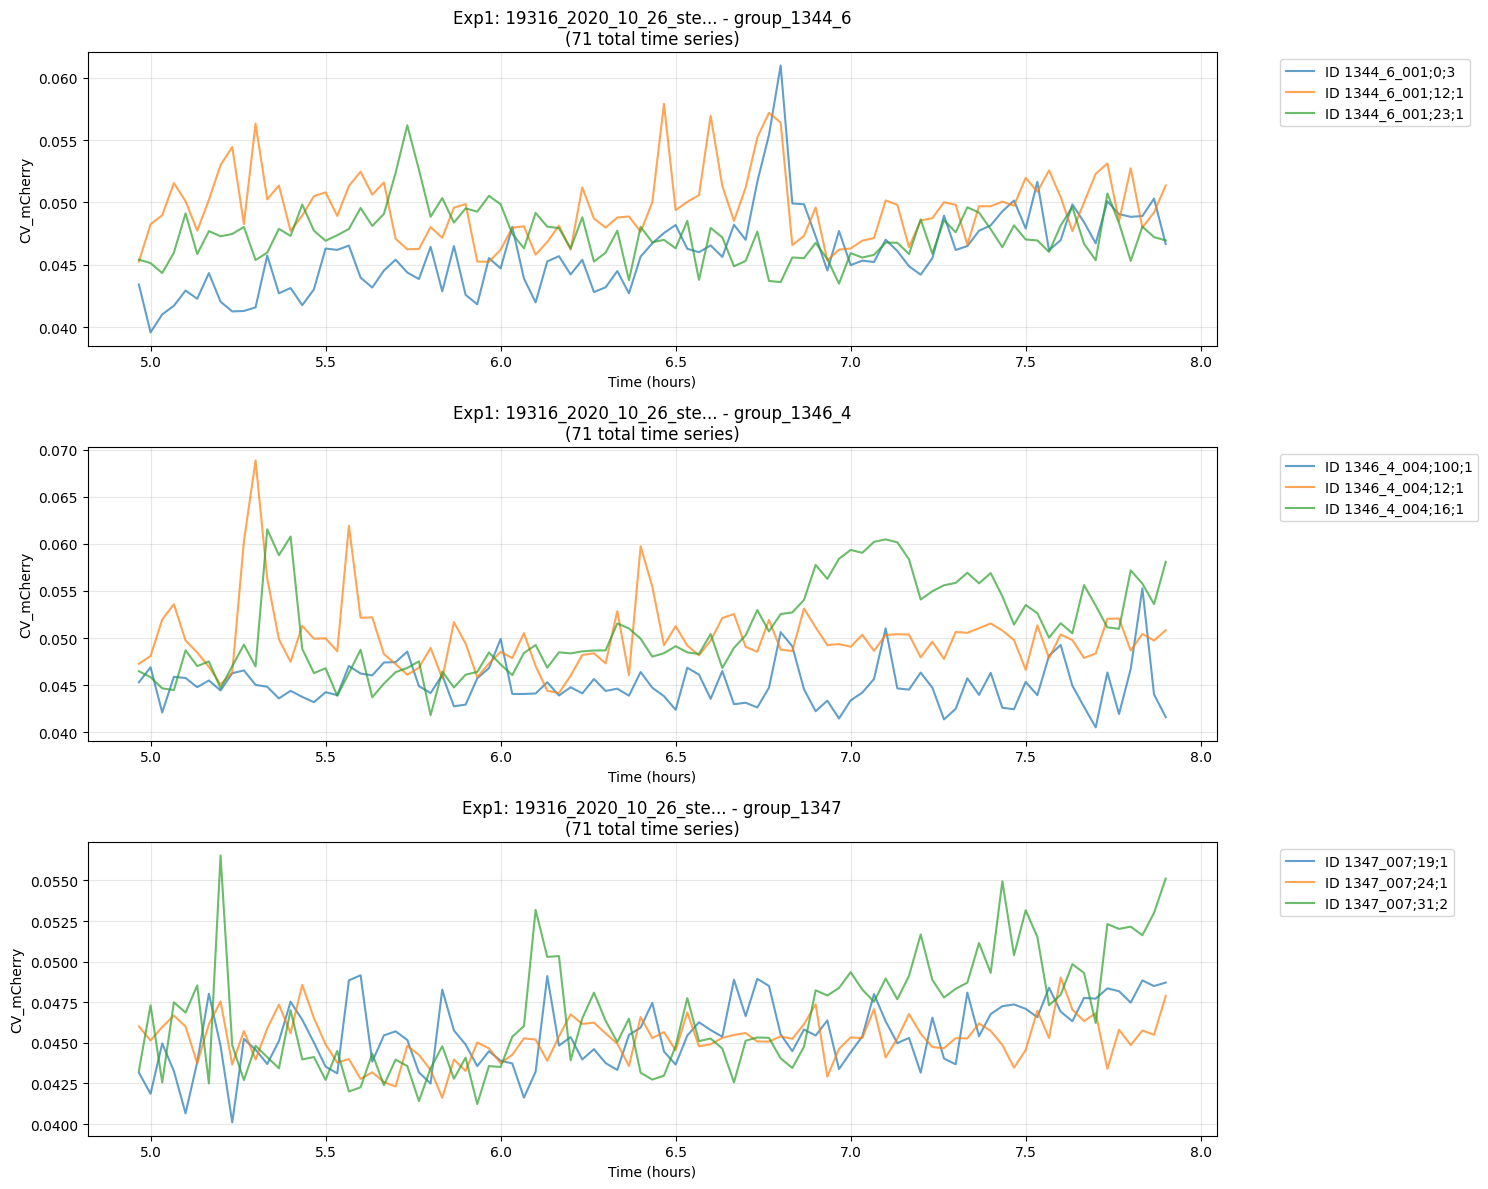

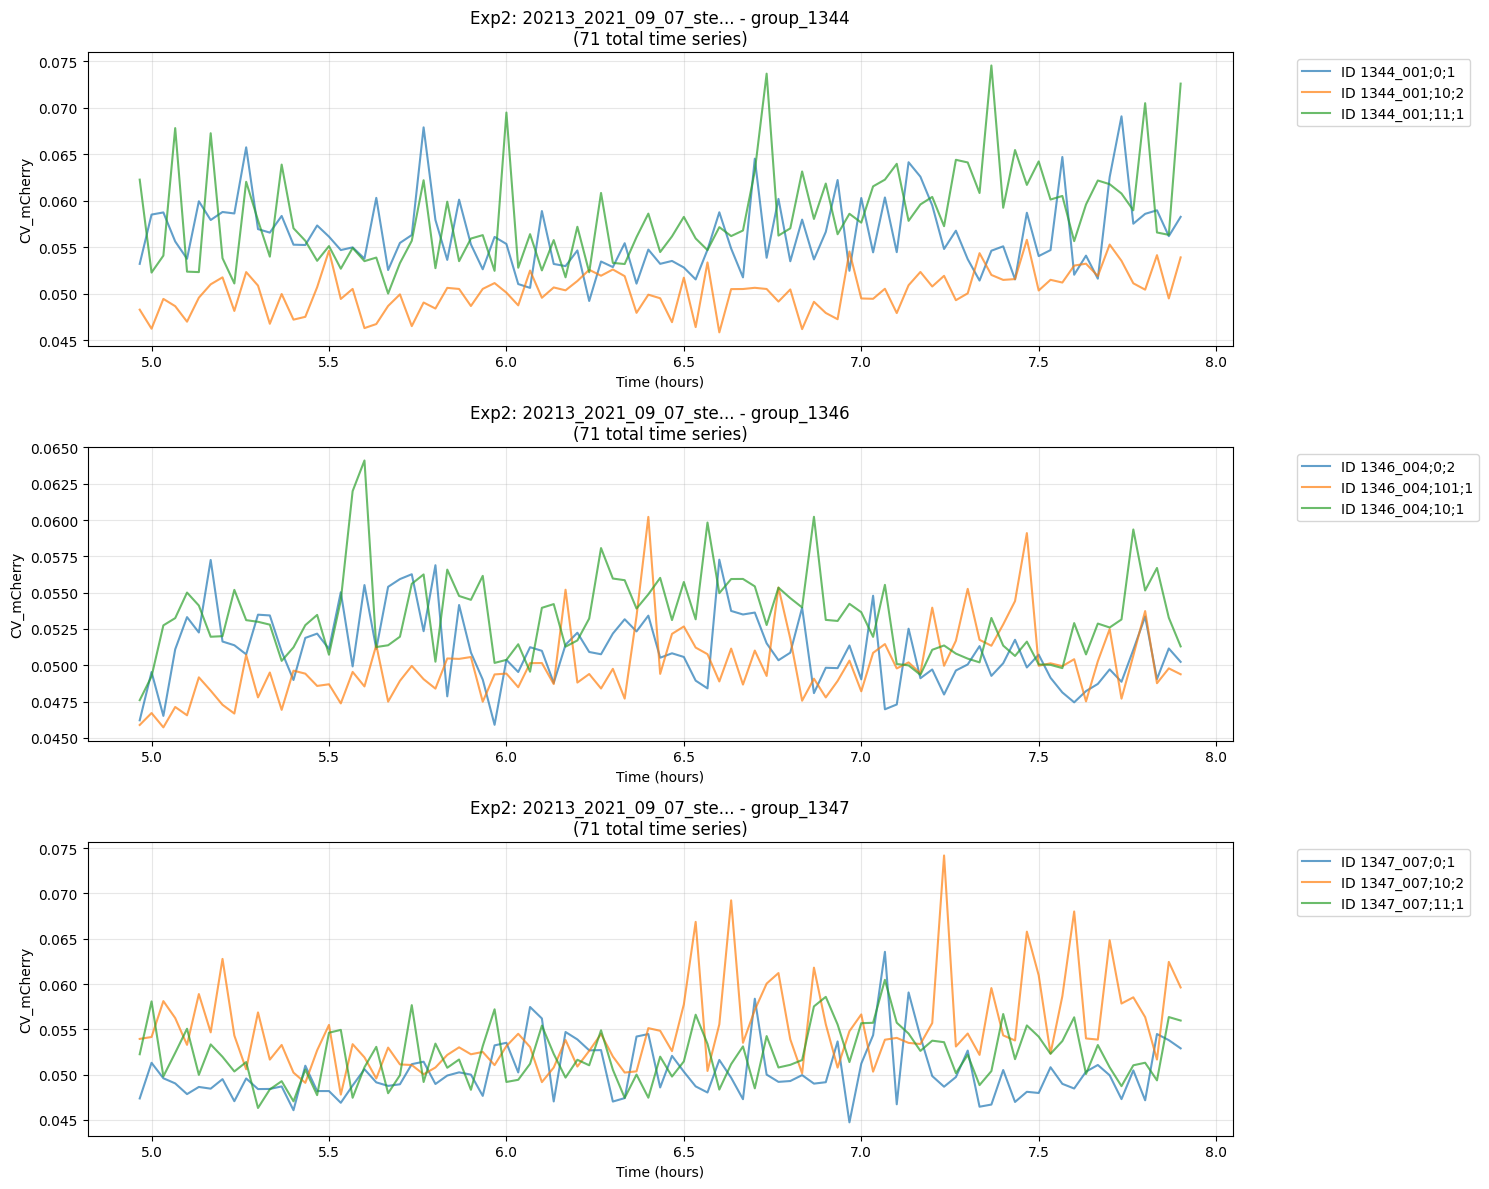

In [21]:
plot_time_series_overview(exp1_time_series_balanced, f"Exp1: {omids[0][:20]}...", max_series=3)
plot_time_series_overview(exp2_time_series_balanced, f"Exp2: {omids[1][:20]}...", max_series=3)

In [22]:
# Check data quality and completeness
print("DATA QUALITY ANALYSIS")
print("="*50)

def analyze_data_quality(time_series_dict, experiment_name):
    """Analyze completeness and quality of time series data"""
    
    print(f"\n{experiment_name}:")
    
    for group_name, df in time_series_dict.items():
        print(f"\n  {group_name}:")
        
        # Get time columns
        time_cols = [col for col in df.columns if col not in ['id', 'group', 'experiment']]
        
        # Calculate statistics
        total_values = len(df) * len(time_cols)
        missing_values = df[time_cols].isnull().sum().sum()
        completeness = (total_values - missing_values) / total_values * 100

        # Time series length statistics
        series_lengths = []
        for idx, row in df.iterrows():
            valid_count = row[time_cols].notna().sum()
            series_lengths.append(valid_count)
        
        print(f"    Total time series: {len(df)}")
        print(f"    Time points per series: {len(time_cols)}")
        print(f"    Data completeness: {completeness:.1f}%")
        print(f"    Series length stats:")
        print(f"      Min: {min(series_lengths)} points")
        print(f"      Max: {max(series_lengths)} points") 
        print(f"      Mean: {np.mean(series_lengths):.1f} points")
        print(f"      Std: {np.std(series_lengths):.1f} points")
        
        # Value range statistics
        all_values = df[time_cols].values.flatten()
        all_values = all_values[~pd.isna(all_values)]
        
        print(f"    CV_mCherry value stats:")
        print(f"      Min: {np.min(all_values):.3f}")
        print(f"      Max: {np.max(all_values):.3f}")
        print(f"      Mean: {np.mean(all_values):.3f}")
        print(f"      Std: {np.std(all_values):.3f}")

analyze_data_quality(exp1_time_series_balanced, f"Experiment 1 ({omids[0][:30]}...)")
analyze_data_quality(exp2_time_series_balanced, f"Experiment 2 ({omids[1][:30]}...)")

DATA QUALITY ANALYSIS

Experiment 1 (19316_2020_10_26_steadystate_g...):

  group_1344_6:
    Total time series: 71
    Time points per series: 89
    Data completeness: 100.0%
    Series length stats:
      Min: 89 points
      Max: 89 points
      Mean: 89.0 points
      Std: 0.0 points
    CV_mCherry value stats:
      Min: 0.038
      Max: 0.087
      Mean: 0.049
      Std: 0.005

  group_1346_4:
    Total time series: 71
    Time points per series: 89
    Data completeness: 100.0%
    Series length stats:
      Min: 89 points
      Max: 89 points
      Mean: 89.0 points
      Std: 0.0 points
    CV_mCherry value stats:
      Min: 0.031
      Max: 0.092
      Mean: 0.048
      Std: 0.006

  group_1347:
    Total time series: 71
    Time points per series: 89
    Data completeness: 100.0%
    Series length stats:
      Min: 89 points
      Max: 89 points
      Mean: 89.0 points
      Std: 0.0 points
    CV_mCherry value stats:
      Min: 0.037
      Max: 0.102
      Mean: 0.048
    

In [23]:
# # Save the transformed data
# print("SAVING TRANSFORMED DATA")
# print("="*30)

# import os

# # Create output directory
# output_dir = "transformed_exp_time_series_data"
# os.makedirs(output_dir, exist_ok=True)

# # Save each group's data as separate CSV files
# def save_time_series_data(time_series_dict, experiment_name, output_dir):
#     """Save each group's time series data to CSV files"""
    
#     saved_files = []
    
#     for group_name, df in time_series_dict.items():
#         # Create filename
#         filename = f"{experiment_name}_{group_name}_time_series.csv"
#         filepath = os.path.join(output_dir, filename)
        
#         # Save to CSV
#         df.to_csv(filepath, index=False)
#         saved_files.append(filepath)
        
#         print(f"Saved: {filename} ({df.shape[0]} x {df.shape[1]})")
    
#     return saved_files

# # Save data for both experiments
# exp1_files = save_time_series_data(exp1_time_series, omids[0], output_dir)
# exp2_files = save_time_series_data(exp2_time_series, omids[1], output_dir)
# balancely labelled data
# exp1_files = save_time_series_data(exp1_time_series_balanced, omids[0], output_dir)
# exp2_files = save_time_series_data(exp2_time_series_balanced, omids[1], output_dir)

# print(f"\nAll files saved to: {output_dir}/")
# print(f"Total files created: {len(exp1_files) + len(exp2_files)}")

## Combine datasets for ML

In [26]:
def create_ml_dataset(exp1_dict, exp2_dict):
    """Combine data from both experiments for machine learning"""
    
    all_time_series = []
    all_labels = []
    all_metadata = []
    
    # Process experiment 1 (label = 0)
    for group_name, df in exp1_dict.items():
        time_cols = [col for col in df.columns if col not in ['id', 'group', 'experiment']]
        
        for idx, row in df.iterrows():
            # Get the time series values
            series_values = row[time_cols].values
            
            # Only include series with sufficient data (at least 50% non-NaN)
            valid_ratio = np.sum(~pd.isna(series_values)) / len(series_values)
            if valid_ratio >= 0.5:  # At least 50% valid data
                all_time_series.append(series_values)
                all_labels.append(0)  # Experiment 1 = label 0
                all_metadata.append({
                    'experiment': row['experiment'],
                    'group': row['group'],
                    'id': row['id'],
                    'valid_ratio': valid_ratio
                })
    
    # Process experiment 2 (label = 1)
    for group_name, df in exp2_dict.items():
        time_cols = [col for col in df.columns if col not in ['id', 'group', 'experiment']]
        
        for idx, row in df.iterrows():
            # Get the time series values
            series_values = row[time_cols].values
            
            # Only include series with sufficient data
            valid_ratio = np.sum(~pd.isna(series_values)) / len(series_values)
            if valid_ratio >= 0.5:
                all_time_series.append(series_values)
                all_labels.append(1)  # Experiment 2 = label 1
                all_metadata.append({
                    'experiment': row['experiment'],
                    'group': row['group'], 
                    'id': row['id'],
                    'valid_ratio': valid_ratio
                })
    
    return all_time_series, all_labels, all_metadata

# Create combined dataset
# combine 1 with 2
# combined_series_1_2, combined_labels_1_2, combined_metadata_1_2 = create_ml_dataset(exp1_time_series, exp2_time_series)

# # balancedly labelled data
combined_series_1_2, combined_labels_1_2, combined_metadata_1_2 = create_ml_dataset(exp1_time_series_balanced, exp2_time_series_balanced)


In [27]:
# Choose which combination to use
combined_series = combined_series_1_2  
combined_labels = combined_labels_1_2
combined_metadata = combined_metadata_1_2

print(f"Combined dataset created:")
print(f"  Total time series: {len(combined_series)}")
print(f"  Label distribution: {np.bincount(combined_labels)}")
print(f"  Experiment 1 (label 0): {np.sum(np.array(combined_labels) == 0)} series")
print(f"  Experiment 2 (label 1): {np.sum(np.array(combined_labels) == 1)} series")

# Show sample metadata
metadata_df = pd.DataFrame(combined_metadata)
print(f"\nMetadata summary:")
print(metadata_df.groupby(['experiment', 'group']).size().to_string())
print(f"\nValid data ratio statistics:")
print(f"  Mean: {metadata_df['valid_ratio'].mean():.3f}")
print(f"  Min: {metadata_df['valid_ratio'].min():.3f}")
print(f"  Max: {metadata_df['valid_ratio'].max():.3f}")

Combined dataset created:
  Total time series: 426
  Label distribution: [213 213]
  Experiment 1 (label 0): 213 series
  Experiment 2 (label 1): 213 series

Metadata summary:
experiment                                         group 
19316_2020_10_26_steadystate_glucose_144m_2w2_00   1344_6    71
                                                   1346_4    71
                                                   1347      71
20213_2021_09_07_steady_0p01glc_1344_1346_1347_00  1344      71
                                                   1346      71
                                                   1347      71

Valid data ratio statistics:
  Mean: 1.000
  Min: 1.000
  Max: 1.000


In [28]:
# Convert to numpy array and determine common length
series_lengths = [len(series) for series in combined_series]
common_length = int(np.percentile(series_lengths, 75))  # Use 75th percentile

print(f"Series length statistics:")
print(f"  Min: {min(series_lengths)}, Max: {max(series_lengths)}")
print(f"  Mean: {np.mean(series_lengths):.1f}, Std: {np.std(series_lengths):.1f}")
print(f"  Using common length: {common_length}")


Series length statistics:
  Min: 89, Max: 89
  Mean: 89.0, Std: 0.0
  Using common length: 89


In [29]:
# Create final dataset - fix dtype issues completely
print("🔧 Preparing final dataset with explicit dtype handling...")

# Check what we're working with
print(f"Combined series length: {len(combined_series)}")
print(f"Combined labels length: {len(combined_labels)}")
print(f"Target common length: {common_length}")

# Process combined_series to ensure consistent length and numeric dtype
X_list = []
y_list = []

for i, (series, label) in enumerate(zip(combined_series, combined_labels)):
    # Debug first few series
    if i < 3:
        print(f"Processing series {i}: length={len(series)}, dtype={series.dtype if hasattr(series, 'dtype') else type(series)}")
    
    if len(series) >= common_length:
        # Truncate to target length
        processed_series = series[:common_length]
    else:
        # Pad with the last value
        processed_series = np.pad(series, (0, common_length - len(series)), mode='edge')
    
    # Ensure it's float and add to list
    processed_series = np.asarray(processed_series, dtype=np.float64)
    X_list.append(processed_series)
    y_list.append(label)

print(f"Created {len(X_list)} processed series")

# Convert to numpy arrays - be very explicit about dtype
print("Converting to final numpy arrays...")
X_final = np.stack(X_list).astype(np.float64)  # Use stack instead of array for consistent shape
y_final = np.array(y_list, dtype=int)

print(f"\n✅ Final dataset created:")
print(f"  Shape: X={X_final.shape}, y={y_final.shape}")
print(f"  X dtype: {X_final.dtype}")
print(f"  Y dtype: {y_final.dtype}")
print(f"  Label distribution: {np.bincount(y_final)}")
print(f"  Data range: [{X_final.min():.3f}, {X_final.max():.3f}]")

# Check for NaN values (should work now)
nan_count = np.isnan(X_final).sum()
if nan_count > 0:
    print(f"⚠️  Warning: {nan_count} NaN values found")
    X_final = np.nan_to_num(X_final, nan=np.nanmean(X_final))
    print("  ✅ Replaced NaN values with global mean")
else:
    print("✅ No NaN values detected")

print("✅ Data preparation complete!")

🔧 Preparing final dataset with explicit dtype handling...
Combined series length: 426
Combined labels length: 426
Target common length: 89
Processing series 0: length=89, dtype=object
Processing series 1: length=89, dtype=object
Processing series 2: length=89, dtype=object
Created 426 processed series
Converting to final numpy arrays...

✅ Final dataset created:
  Shape: X=(426, 89), y=(426,)
  X dtype: float64
  Y dtype: int64
  Label distribution: [213 213]
  Data range: [0.031, 0.102]
✅ No NaN values detected
✅ Data preparation complete!


## Machine Learning / Deep Learning

In [30]:
# Import custom classifiers from the codebase
import sys
from pathlib import Path

# Ensure the src directory is on the Python path
sys.path.append(str(Path("/home/ianyang/stochastic_simulations/src").resolve()))
# from classifiers.svm_classifier import svm_classifier
################## MANUALLY IMPORTING THIS FUNCTION AS THE CALL DIDNT WORK! #######################
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)
import pandas as pd
from typing import Dict, Optional

def svm_classifier(X_train, X_test, y_train, y_test, 
                   svm_C=1.0, 
                   svm_gamma='scale', 
                   svm_kernel='rbf',
                   print_classification_report=False,
                   print_confusion_matrix=False,
                   ):
    """
    Trains a basic SVM model for classification and evaluates the model.
    
    Parameters:
        X_train, X_test, y_train, y_test: Split data
        svm_C: Regularization parameter (default: 1.0)
        svm_gamma: Kernel coefficient for 'rbf', 'poly', and 'sigmoid' (default: 'scale') 
        svm_kernel: Specifies the kernel type to be used in the algorithm (default: 'rbf')
    
    Returns:
        accuracy: Classification accuracy of the SVM
    
    Example:
        >>> from sklearn.datasets import make_classification
        >>> from sklearn.model_selection import train_test_split
        >>> X, y = make_classification(n_samples=100, n_features=4, n_classes=2, random_state=42)
        >>> X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        >>> accuracy = svm_classifier(X_train, X_test, y_train, y_test, svm_C=1.0, svm_kernel='rbf')
        === SVM (RBF Kernel) Classification Accuracy: 0.87 ===
        >>> print(f"Accuracy: {accuracy}")
        Accuracy: 0.87
    """
    # Train a basic SVM model without grid search
    svm_model = SVC(C=svm_C, gamma=svm_gamma, kernel=svm_kernel)
    svm_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = svm_model.predict(X_test)
    svm_acc = accuracy_score(y_test, y_pred)
    if svm_kernel == 'rbf':
        print(f"=== SVM (RBF Kernel) Classification Accuracy: {svm_acc:.2f} ===")
    elif svm_kernel == 'linear':
        print(f"=== SVM (Linear Kernel) Classification Accuracy: {svm_acc:.2f} ===")

    if print_classification_report:
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

    if print_confusion_matrix:
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

    return svm_acc
################## MANUALLY IMPORTING THIS FUNCTION AS THE CALL DIDNT WORK! #######################

from classifiers.lstm_classifier import lstm_classifier
from classifiers.transformer_classifier import transformer_classifier

print("Custom classifiers imported successfully!")

Custom classifiers imported successfully!


## Dataset splitting & classification

In [31]:
# Split data for custom classifiers
print("SPLITTING DATA FOR CUSTOM CLASSIFIERS")
print("="*45)

# Split into train/validation/test sets
X_temp, X_test_custom, y_temp, y_test_custom = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)
X_train_custom, X_val_custom, y_train_custom, y_val_custom = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("Data split for custom classifiers:")
print(f"  Training: {X_train_custom.shape[0]} samples")
print(f"  Validation: {X_val_custom.shape[0]} samples")
print(f"  Test: {X_test_custom.shape[0]} samples")
print(f"  Training label distribution: {np.bincount(y_train_custom)}")
print(f"  Validation label distribution: {np.bincount(y_val_custom)}")
print(f"  Test label distribution: {np.bincount(y_test_custom)}")

# Run custom classifiers
print("\n" + "="*60)
print("RUNNING CUSTOM CLASSIFIERS")
print("="*60)

# 1. SVM Classifier
print("\n🔧 Running SVM Classifier...")
svm_rbf_accuracy = svm_classifier(X_train_custom, X_test_custom, y_train_custom, y_test_custom)
print(f"✅ SVM (RBF) Accuracy: {svm_rbf_accuracy:.4f}")

# 2. LSTM Classifier with advanced features
print("\n🔧 Running LSTM Classifier with advanced features...")
iy001a_lstm_accuracy = lstm_classifier(
    X_train_custom,
    X_val_custom,
    X_test_custom,
    y_train_custom,
    y_val_custom,
    y_test_custom,
    epochs=100,
    hidden_size=128,
    num_layers=4,
    dropout_rate=0.2,
    learning_rate=0.001,
    batch_size=64,
    use_conv1d=True,
    use_attention=True,
    num_attention_heads=4,
    use_auxiliary=True,
)
print(f"✅ Advanced LSTM Accuracy: {iy001a_lstm_accuracy:.4f}")

# 3. Transformer Classifier with advanced features
print("\n🔧 Running Transformer Classifier with advanced features...")
transformer_full_accuracy = transformer_classifier(
    X_train_custom,
    X_val_custom,
    X_test_custom,
    y_train_custom,
    y_val_custom,
    y_test_custom,
    d_model=128,
    nhead=8,
    num_layers=4,
    epochs=50,
    use_conv1d=True,
    use_auxiliary=True,
)
print(f"✅ Advanced Transformer Accuracy: {transformer_full_accuracy:.4f}")

print("\n🎉 All custom classifiers completed successfully!")

SPLITTING DATA FOR CUSTOM CLASSIFIERS
Data split for custom classifiers:
  Training: 255 samples
  Validation: 85 samples
  Test: 86 samples
  Training label distribution: [127 128]
  Validation label distribution: [43 42]
  Test label distribution: [43 43]

RUNNING CUSTOM CLASSIFIERS

🔧 Running SVM Classifier...
=== SVM (RBF Kernel) Classification Accuracy: 0.85 ===
✅ SVM (RBF) Accuracy: 0.8488

🔧 Running LSTM Classifier with advanced features...
=== LSTM with Conv1D and 4-Head Attention Accuracy: 0.87 ===
✅ Advanced LSTM Accuracy: 0.8721

🔧 Running Transformer Classifier with advanced features...
=== LSTM with Conv1D and 4-Head Attention Accuracy: 0.87 ===
✅ Advanced LSTM Accuracy: 0.8721

🔧 Running Transformer Classifier with advanced features...
=== Transformer with Conv1D and Auxiliary Task Accuracy: 0.83 ===
✅ Advanced Transformer Accuracy: 0.8256

🎉 All custom classifiers completed successfully!
=== Transformer with Conv1D and Auxiliary Task Accuracy: 0.83 ===
✅ Advanced Transfo

COMPREHENSIVE MODEL COMPARISON
🏆 CUSTOM CLASSIFIERS RESULTS:
      Model  Accuracy                                       Features
  SVM (RBF)  0.848837                                     RBF Kernel
       LSTM  0.872093            Conv1D + Attention + Auxiliary Loss
Transformer  0.825581 Conv1D + Multi-head Attention + Auxiliary Loss

🥇 BEST PERFORMING MODEL:
   Model: LSTM
   Accuracy: 0.8721
   Features: Conv1D + Attention + Auxiliary Loss


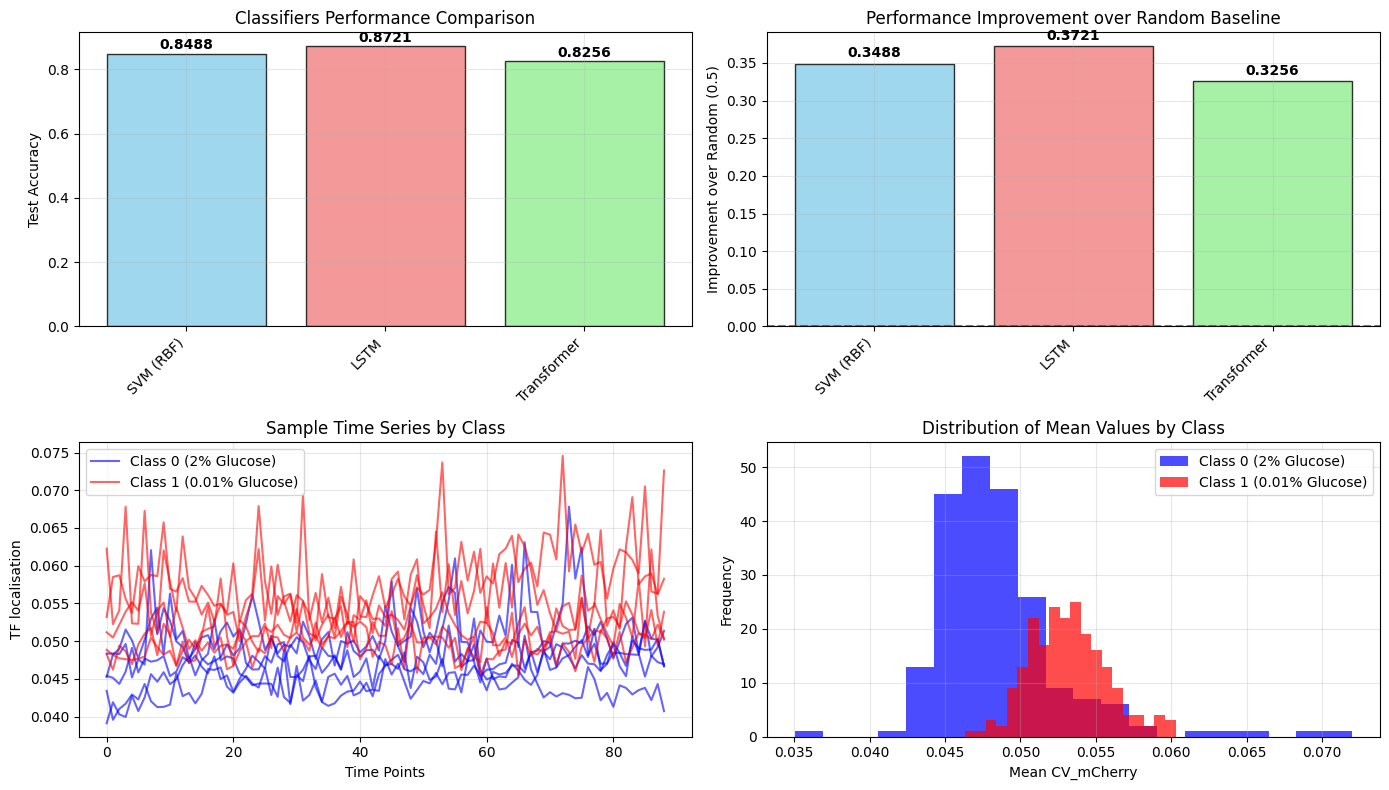


📊 STATISTICAL ANALYSIS:
   Class 0 (2% Glucose) mean CV: 0.049 ± 0.004
   Class 1 (0.01% Glucose) mean CV: 0.053 ± 0.003
   T-test: t=-13.582, p=0.000000
   Statistically significant: Yes (p < 0.05)

🔍 EXPERIMENT SUMMARY:
   Total time series analyzed: 426
   Time series length: 89 time points
   Classes: 2 (glucose conditions)
   Best model achieved 87.2% accuracy


In [32]:
# Compare all classifier results
print("="*70)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*70)

# Create comprehensive results summary
comprehensive_results = pd.DataFrame({
    'Model': [
        'SVM (RBF)',
        'LSTM', 
        'Transformer'
    ],
    'Accuracy': [
        svm_rbf_accuracy,
        iy001a_lstm_accuracy,
        transformer_full_accuracy
    ],
    'Features': [
        'RBF Kernel',
        'Conv1D + Attention + Auxiliary Loss',
        'Conv1D + Multi-head Attention + Auxiliary Loss'
    ]
})

print("🏆 CUSTOM CLASSIFIERS RESULTS:")
print(comprehensive_results.to_string(index=False))

# Find best model
best_idx = comprehensive_results['Accuracy'].idxmax()
best_model = comprehensive_results.loc[best_idx, 'Model']
best_accuracy = comprehensive_results.loc[best_idx, 'Accuracy']

print(f"\n🥇 BEST PERFORMING MODEL:")
print(f"   Model: {best_model}")
print(f"   Accuracy: {best_accuracy:.4f}")
print(f"   Features: {comprehensive_results.loc[best_idx, 'Features']}")

# Visualize results
plt.figure(figsize=(14, 8))

# Bar plot of accuracies
plt.subplot(2, 2, 1)
colors = ['skyblue', 'lightcoral', 'lightgreen']
bars = plt.bar(range(len(comprehensive_results)), comprehensive_results['Accuracy'], 
               color=colors, alpha=0.8, edgecolor='black')
plt.xticks(range(len(comprehensive_results)), comprehensive_results['Model'], rotation=45, ha='right')
plt.ylabel('Test Accuracy')
plt.title('Classifiers Performance Comparison')
plt.grid(True, alpha=0.3)

# Add accuracy values on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot difference from random baseline (0.5)
plt.subplot(2, 2, 2)
baseline = 0.5
improvements = comprehensive_results['Accuracy'] - baseline
bars2 = plt.bar(range(len(comprehensive_results)), improvements, 
                color=colors, alpha=0.8, edgecolor='black')
plt.xticks(range(len(comprehensive_results)), comprehensive_results['Model'], rotation=45, ha='right')
plt.ylabel('Improvement over Random (0.5)')
plt.title('Performance Improvement over Random Baseline')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)

# Add improvement values on bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# Sample time series from each class
plt.subplot(2, 2, 3)
class_0_indices = np.where(y_final == 0)[0]
class_1_indices = np.where(y_final == 1)[0]

class_0_means = [np.mean(X_final[i]) for i in class_0_indices]
class_1_means = [np.mean(X_final[i]) for i in class_1_indices]
# Plot sample time series
for i in range(min(5, len(class_0_indices))):
    plt.plot(X_final[class_0_indices[i]], alpha=0.6, color='blue', label='Class 0 (2% Glucose)' if i == 0 else "")
for i in range(min(5, len(class_1_indices))):
    plt.plot(X_final[class_1_indices[i]], alpha=0.6, color='red', label='Class 1 (0.01% Glucose)' if i == 0 else "")

# plt.plot(class_0_means, alpha=0.6, color='blue', label='Class 0' if i == 0 else "")
# plt.plot(class_1_means, alpha=0.6, color='red', label='Class 1' if i == 0 else "")

plt.xlabel('Time Points')
plt.ylabel('TF localisation')
plt.title('Sample Time Series by Class')
plt.legend()
plt.grid(True, alpha=0.3)

# Data distribution
plt.subplot(2, 2, 4)


plt.hist(class_0_means, alpha=0.7, label='Class 0 (2% Glucose)', bins=20, color='blue')
plt.hist(class_1_means, alpha=0.7, label='Class 1 (0.01% Glucose)', bins=20, color='red')
plt.xlabel('Mean CV_mCherry')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Values by Class')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical significance test
from scipy import stats

print(f"\n📊 STATISTICAL ANALYSIS:")
print(f"   Class 0 (2% Glucose) mean CV: {np.mean(class_0_means):.3f} ± {np.std(class_0_means):.3f}")
print(f"   Class 1 (0.01% Glucose) mean CV: {np.mean(class_1_means):.3f} ± {np.std(class_1_means):.3f}")

# T-test
t_stat, p_value = stats.ttest_ind(class_0_means, class_1_means)
print(f"   T-test: t={t_stat:.3f}, p={p_value:.6f}")
print(f"   Statistically significant: {'Yes' if p_value < 0.05 else 'No'} (p < 0.05)")

print(f"\n🔍 EXPERIMENT SUMMARY:")
print(f"   Total time series analyzed: {len(X_final)}")
print(f"   Time series length: {X_final.shape[1]} time points")
print(f"   Classes: 2 (glucose conditions)")
print(f"   Best model achieved {best_accuracy:.1%} accuracy")

In [33]:
# Save comprehensive results
print("💾 SAVING COMPREHENSIVE RESULTS")
print("="*35)

# Create detailed results dataframe
final_results = pd.DataFrame({
    'Experiment_ID': ['IY010_custom_classifiers'],
    'Experiment_0': [omids[0]],
    'Experiment_1': [omids[1]],
    'Target_Column': ['CV_mCherry'],
    'Total_Time_Series': [len(X_final)],
    'Time_Series_Length': [X_final.shape[1]],
    'Train_Samples': [X_train_custom.shape[0]],
    'Val_Samples': [X_val_custom.shape[0]],
    'Test_Samples': [X_test_custom.shape[0]],
    'Custom_SVM_Accuracy': [svm_rbf_accuracy],
    'Custom_LSTM_Accuracy': [iy001a_lstm_accuracy],
    'Custom_Transformer_Accuracy': [transformer_full_accuracy],
    'Best_Model': [best_model],
    'Best_Accuracy': [best_accuracy],
    'Class_0_Mean_CV': [np.mean(class_0_means)],
    'Class_1_Mean_CV': [np.mean(class_1_means)],
    'T_Test_P_Value': [p_value],
    'Statistically_Significant': [p_value < 0.05]
})

# Save main results
results_file = "IY010_custom_classifiers_results.csv"
final_results.to_csv(results_file, index=False)

# Save detailed model comparison
model_comparison_file = "IY010_model_comparison.csv"
comprehensive_results.to_csv(model_comparison_file, index=False)

# Save time series metadata
metadata_file = "IY010_time_series_metadata.csv"
pd.DataFrame(combined_metadata).to_csv(metadata_file, index=False)

print(f"✅ Results saved:")
print(f"   Main results: {results_file}")
print(f"   Model comparison: {model_comparison_file}")
print(f"   Time series metadata: {metadata_file}")

print(f"\n📋 FINAL SUMMARY:")
print("="*50)
for _, row in final_results.iterrows():
    print(f"🔬 Experiment: {row['Experiment_ID']}")
    print(f"📊 Data: {row['Total_Time_Series']} time series × {row['Time_Series_Length']} time points")
    print(f"🎯 Target: {row['Target_Column']}")
    print(f"🏆 Best Model: {row['Best_Model']} ({row['Best_Accuracy']:.4f} accuracy)")
    print(f"📈 Statistical significance: {'Yes' if row['Statistically_Significant'] else 'No'} (p = {row['T_Test_P_Value']:.6f})")
    print(f"💡 Classes are {'clearly distinguishable' if row['Best_Accuracy'] > 0.8 else 'moderately distinguishable' if row['Best_Accuracy'] > 0.7 else 'challenging to distinguish'}")

print(f"\n🎉 Analysis complete! Custom classifiers from your codebase successfully applied to experimental data.")

💾 SAVING COMPREHENSIVE RESULTS
✅ Results saved:
   Main results: IY010_custom_classifiers_results.csv
   Model comparison: IY010_model_comparison.csv
   Time series metadata: IY010_time_series_metadata.csv

📋 FINAL SUMMARY:
🔬 Experiment: IY010_custom_classifiers
📊 Data: 426 time series × 89 time points
🎯 Target: CV_mCherry
🏆 Best Model: LSTM (0.8721 accuracy)
📈 Statistical significance: Yes (p = 0.000000)
💡 Classes are clearly distinguishable

🎉 Analysis complete! Custom classifiers from your codebase successfully applied to experimental data.
